In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
import calendar
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from utils import oneHot, batch
import random
from __future__ import print_function
import tensorflow as tf
from tensorflow import reset_default_graph
import IPython.display as display
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline  

/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc", line #513
  (fname, cnt))


## read data and preprocess

In [9]:
df = pd.read_csv('cleaned_sales+weather_data.csv')
df = df.drop('Unnamed: 0' , 1)

In [10]:
df['date'] = df['date'].map( lambda x: datetime.strptime( x, '%Y-%m-%d'))
df['weekofyear'] = df['date'].dt.weekofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['dayofyear'] = df['date'].dt.dayofyear
df['station'] = df['station'].map( int )
df['year'] = df['date'].dt.year
# filter
df = df[df['oms'] > 0 ]
df[:10]

,EAN,Produkttekst,avance,chain_store,date,oms,postal_no,store_name,store_no,volume,station,temp,wind,sun,precipitations,weekofyear,month,weekday,dayofyear,year
0,5741000116975,Royal B X-mas 6x33ds,1,DagliBrugsen,2015-01-01,31.00,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
1,5741000131084,Royal Export 6x33 ds,-13,DagliBrugsen,2015-01-01,100.00,2300,COOP DAGLIBR BRYDES ALLE,1043,4,618800,5.5,6.1,0,1.9,1,1,3,1,2015
2,5741000140284,ROYAL PLATINUM 6-PAK,8,DagliBrugsen,2015-01-01,39.95,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
3,5741000131084,Royal Export 6x33 ds,17,DagliBrugsen,2015-01-01,79.90,2400,COOP DAGLIBR BISPEPARKEN,1053,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
4,5741000132463,Royal Exp. kuffert24,-19,DagliBrugsen,2015-01-01,299.85,2650,COOP LOKALBR FJELDSTEDVEJ,1082,3,618800,5.5,6.1,0,1.9,1,1,3,1,2015
5,5741000116494,Royal Class. 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
6,5741000117958,Royal Plsnr 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
7,5741000131077,Royal Export ds,7,DagliBrugsen,2015-01-01,24.00,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
8,5741000132463,Royal Exp. kuffert24,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
9,5741000135013,HEINEKEN KUFFERT,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015


In [28]:
light = ["royal free"]
shandy = ["ru shandy grape", "shandy lemon-gin", "shandy lem-ginger", "shandy lem/gin", "ru shandy lem/ginger"]
pilsner = ["royal pils", "royal plsnr", "royal class.", "royal pilsner", "royal classic", "maribo classic", "slots pilsner", 
           "odense pilsner", "odense class", "maribo pilsner", "ceres pilsner", "ceres classic", "ceres top classic",
           "odense pils.", "ceres top pls", "thor pilsner", "royal red", "thor classic", "faxe fad", "faxe pilsner", 
           "øko pilsner", "ru pilsner øko", "øko royal pils."]
strong_pils = ["royal export", "royal exp.", "royal ex.", "blå nykøbing", "royal platinum", "blå thor", "havskum"]
holiday = ["royal blå x-mas", "royal b x-mas", "royal hvid x-mas", "x-mas hvid", "x-mas blaa", 
             "ceres julehvidtøl", "x-mas", "ceres hvidtøl", "albani j.bryg", "albani påskebryg"]
extra_strong = ["albani giraf", "giraf beer", "giraf black", "albani blålys", "h.c. andersen", "h.c.anders","dortmunder"]
special = ["royal stout", "royal english ale", "royal engl ale", "schiøtz gylden ipa", "schiøtz bohemian", 
        "schiøtz mørk mumme", "schiøtz mørk bock", "schiøtz belgisk ipa", "schiøtz gaveæske", "odense 1859", 
        "ceres red erik", "royal strong ale", "albani mosaic ipa", "get it specialøl"]
imported = ["heineken", "sol", "newcastle br ale", "edelweiss snowfresh"]

def parseBeerType(s):
    s = s.lower()
    if any(t in s for t in light):
        return "light"
    elif any(t in s for t in pilsner):
        return "pilsner"
    elif any(t in s for t in strong_pils):
        return "strong_pils"
    elif any(t in s for t in holiday):
        return "holiday"
    elif any(t in s for t in extra_strong):
        return "extra_strong"
    elif any(t in s for t in special):
        return "special"
    elif any(t in s for t in imported):
        return "imported"
    elif any(t in s for t in shandy):
        return "shandy"
    else:
        # only used while testing
        #print s
        return "other"

pint = ["50 cl", "pint", "50", "schiøtz"]
gift_pack = ["m/4"]
six_pack = ["6-pack", "6x33", "6x33ds", "6-pak", "6fl", "6-pk"]
nine_pack = ["9x33ds"]
twelve_pack = ["12x33"]
crate = ["kuffert", "kuffert24", "24ds"]

def parseBeerSize(s):
    if any(size in s for size in pint):
        return "pint"
    #elif any(size in s for size in gift_pack):
    #    return "gift_pack"
    elif any(size in s for size in six_pack):
        return "six_pack"
    elif any(size in s for size in nine_pack):
        return "nine_pack"  
    elif any(size in s for size in twelve_pack):
        return "twelve_pack"
    elif any(size in s for size in crate):
        return "crate"
    else:
        return "single"
    
def parseBeerVolume(s):
    if any(size in s for size in pint):
        return 50
    elif any(size in s for size in gift_pack):
        return 150
    elif any(size in s for size in six_pack):
        return 33*6
    elif any(size in s for size in nine_pack):
        return 33*9 
    elif any(size in s for size in twelve_pack):
        return 12*33
    elif any(size in s for size in crate):
        return 24*33
    else:
        return 33

In [29]:
df['type'] = df['Produkttekst'].map(parseBeerType)
df['pack'] = df['Produkttekst'].map(parseBeerSize)
df['item_volume'] = df['Produkttekst'].map(parseBeerVolume)

In [30]:
x = df['item_volume'] * df['volume']
df['total_volume'] = x

## aggregate

Aggregate the data per station and day

In [230]:
features = ['total_volume', 'pack', 'type','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station']
q = df[features]
q[:3]

,total_volume,pack,type,date,temp,sun,wind,precipitations,dayofyear,year,month,weekday,station
0,198,six_pack,holiday,2015-01-01,5.5,0,6.1,1.9,1,2015,1,3,618800
1,792,six_pack,strong_pils,2015-01-01,5.5,0,6.1,1.9,1,2015,1,3,618800
2,33,single,strong_pils,2015-01-01,5.5,0,6.1,1.9,1,2015,1,3,618800


In [231]:
def doubleOneHot(df , a,b):
    res = dict()
    for aa in set(df[a]):
        for bb in set(df[b]):
            aaa = df[a].values
            bbb = df[b].values
            res[a+'='+aa+'&&'+b+'='+bb] = [ int( aa == aaa[i] and bb == bbb[i] ) for i in range(len(df)) ]
    for k, s in res.items():
        df[k] = s
    df = df.drop(a, 1)
    df = df.drop(b, 1)
    return df

q = doubleOneHot(q , 'type' , 'pack')

/Users/valentin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [232]:
qq = q 
labels = []
for t in q.columns.values:
    if '&&' in t:
        labels.append(t)
        qq[t] = qq[t] * qq['total_volume'] 

qq[:3]

,total_volume,date,temp,sun,wind,precipitations,dayofyear,year,month,weekday,...,type=imported&&pack=nine_pack,type=extra_strong&&pack=crate,type=imported&&pack=six_pack,type=shandy&&pack=six_pack,type=extra_strong&&pack=pint,type=imported&&pack=single,type=pilsner&&pack=single,type=holiday&&pack=crate,type=other&&pack=six_pack,type=special&&pack=six_pack
0,198,2015-01-01,5.5,0,6.1,1.9,1,2015,1,3,...,0,0,0,0,0,0,0,0,0,0
1,792,2015-01-01,5.5,0,6.1,1.9,1,2015,1,3,...,0,0,0,0,0,0,0,0,0,0
2,33,2015-01-01,5.5,0,6.1,1.9,1,2015,1,3,...,0,0,0,0,0,0,0,0,0,0


In [308]:
data = qq#[ (q['month'] > 3) & (q['month'] < 10 ) ] #& (q['weekday'] == 4)]
# aggregate emp	wind	sun	precipitations
agg = data.groupby(['date', 'station'  ])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() 
                                 , 'weekday' :  agg['weekday'].first()
                                 , 'temp':agg['temp'].first() 
                                 , 'sun' : agg['sun'].first()
                                 , 'wind' : agg['wind'].first()
                                 ,  'precipitations' : agg['precipitations'].first() 
                                 , 'year' : agg['year'].first() } )
for l in labels:
    aggregated_data[l] =  agg[l].sum() 
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)

print(len(labels))
for k in labels:
    if np.sum( aggregated_data[k].values) == 0:
        aggregated_data = aggregated_data.drop(k,1)
        labels.remove(k)
        print(k)
# manual labels to remove
#labels.remove('type=strong_pils&&pack=nine_pack')
#labels.remove('type=other&&pack=six_pack')
#labels.remove('type=special&&pack=single')
#labels.remove('type=holiday&&pack=single')
#labels.remove('type=pilsner&&pack=pint')
#labels.remove('type=holiday&&pack=six_pack') # sure?
#labels.remove('type=extra_strong&&pack=single')
#labels.remove('type=shandy&&pack=six_pack')
#labels.remove('type=other&&pack=six_pack')
#labels.remove("type=special&&pack=pint")

print(len(labels))
aggregated_data[:3]

18
18


,index,station,date,month,precipitations,sun,temp,weekday,wind,year,...,type=pilsner&&pack=crate,type=light&&pack=single,type=shandy&&pack=single,type=strong_pils&&pack=pint,type=strong_pils&&pack=six_pack,type=imported&&pack=six_pack,type=extra_strong&&pack=pint,type=imported&&pack=single,type=pilsner&&pack=single,type=special&&pack=six_pack
0,0,603100,2015-01-01,1,4.5,0,6.7,3,8.7,2015,...,11880,132,0,1500,12474,6930,2350,1683,3399,594
1,1,607200,2015-01-01,1,1.0,0,6.8,3,5.7,2015,...,18216,396,0,2250,24552,9900,4750,2508,36366,792
2,2,612600,2015-01-01,1,0.3,0,5.4,3,8.6,2015,...,6336,66,66,2050,21978,5940,3850,1518,25443,0


In [309]:
#for l in labels:
#    if "single" not in l:
#        labels.remove(l)
#print(labels)

### remove outlier

In [310]:
#print (len(aggregated_data))
#for ll in labels:
#    print(ll)
#    Q1 = np.percentile(aggregated_data[ll] , 25)
#    Q3 = np.percentile(aggregated_data[ll] , 75)
#    limit = Q3 + 1.5 * (Q3-Q1)
#    aggregated_data = aggregated_data[ aggregated_data[ll] < limit ]
#print (len(aggregated_data))

## normalize 

Results are really bad with it. Thus, we keep the data unormalized for now.

In [311]:
#from sklearn import preprocessing
#def normalize(X):
#    mean = np.mean(X)
#    std = np.std(X)
#    return (X - mean)/std
#aggregated_data['precipitations'] = normalize(aggregated_data['precipitations'])
#aggregated_data['oms'] = normalize(aggregated_data['oms'])
#aggregated_data['wind'] = normalize(aggregated_data['wind'])
#aggregated_data['sun'] = normalize(aggregated_data['sun'])
#aggregated_data['temp'] = normalize(aggregated_data['temp'])
#aggregated_data[:3]
#aggregated_data.describe()

## setup train and tests splits from the dataset

Keep a sparated split of data for testing

In [312]:
features = ['month','weekday','station', 'precipitations','sun','temp','wind']
data = aggregated_data[features]
data = oneHot(data, 'weekday')
data = oneHot(data, 'station')
data = oneHot(data, 'month')
features = data.columns.values
#labels = ['oms']
X = data.as_matrix()
yy = aggregated_data[labels].values
data.describe()

,precipitations,sun,temp,wind,weekday=0,weekday=1,weekday=2,weekday=3,weekday=4,weekday=5,...,month=12,month=8,month=9,month=6,month=7,month=4,month=5,month=2,month=3,month=1
count,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,...,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000
mean,2.029668,4.902447,9.475498,3.890846,0.141994,0.141994,0.141994,0.143505,0.143505,0.143505,...,0.046828,0.093656,0.090634,0.090634,0.093656,0.090634,0.093656,0.086103,0.093656,0.093656
std,3.996513,4.328633,5.938170,1.882317,0.349097,0.349097,0.349097,0.350640,0.350640,0.350640,...,0.211302,0.291393,0.287132,0.287132,0.291393,0.287132,0.291393,0.280558,0.291393,0.291393
min,0.000000,0.000000,-9.300000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.900000,4.725000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.100000,4.100000,9.400000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.300000,7.900000,14.500000,4.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,37.900000,16.100000,23.700000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [313]:
full_training = False
train_ratio = 0.9
L = len(yy)
idx = range(L)
random.seed(0)
random.shuffle(idx)
if not full_training:
    X_train = X[ idx[ : int( train_ratio * L)  ]  , : ]
    y_train = yy[ idx[ : int( train_ratio * L)  ] , : ]
else:
    X_train = X
    y_train = yy
X_test = X[ idx[ int( train_ratio * L)  : ]  , : ]
y_test = yy[ idx[ int( train_ratio * L)  : ] , :]

## define accuracy function

define an accuracy function 

In [314]:
from scipy.spatial import distance
def getErr(pred,true):
    dst = distance.euclidean(pred,true)
    return dst / np.linalg.norm(true)

def rawErr(pred,true):
    return distance.euclidean(pred,true)

getErr([200, 400, 500],[200, 400, 500])
#getErr([200, 400, 500],[200, 300, 500])

0.0

# Random Forest Regressor

This simple model gives a 40% error, quite bad

mean error: 0.401992045596
std error: 0.317179265449


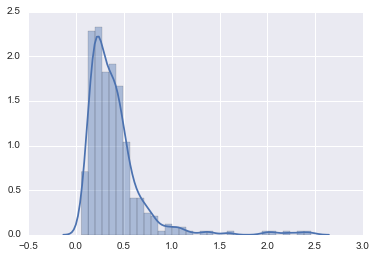

In [315]:
# define the model
rfr = RandomForestRegressor(n_estimators=300, min_samples_split=5)
# train it
rfr.fit(X_train, y_train)
# predict outputs
pred = rfr.predict(X_test)
# compute mean accuracy
scores = []
raw_scores = []
for i in range(len(pred)):
    e = getErr(pred[i],y_test[i])
    scores.append(e)
    raw_scores.append(pred[i] / y_test[i])
print("mean error: " + str(np.mean(scores)))
print("std error: " + str(np.std(scores)))
sns.distplot(scores)
plt.show()

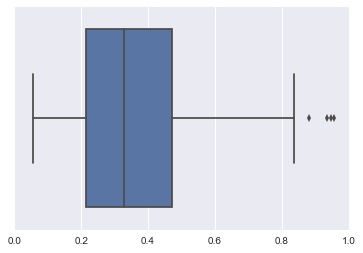

In [316]:
sns.boxplot(scores)
plt.xlim([0,1])
plt.show()

# build a feed forward neural network using tensorflow 

Using Tensorflow enable us to modify easily our models (to a multiclass regression problem for example)

some inspiration:
* http://stackoverflow.com/questions/34208336/tensorflow-multivariate-linear-regression-not-converging 
* http://stackoverflow.com/questions/36637901/building-a-non-linear-model-with-relus-in-tensorflow


### Here is my model: feed forward network with one hidden layer

- one layer + ReLU units
- one hidden layer + ReLU units
- output

- the cost is the Mean Squared Error (regression problem)

<img src="images/regressor_net.png">



In [323]:
tf.reset_default_graph()

# hyperparameters and graph-specific values
logs_path = '/tmp/tensorflow_logs/OiX-regressor'
epoches = 200
batch_len = 64
hidden_units = 24
learning_rate =  1e-1
n_input = X_train.shape[1]
n_output = y_train.shape[1]

# define a batch generator (stochastic gradient descent)
batch_gen = batch(X_train,y_train,batch_len)

def weight_variable(shape , name='xxx'):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

def bias_variable(shape, name='xxx'):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

# create placeholders to pass the data to the model
x = tf.placeholder('float', shape=[None, n_input], name='InputData')
y_ = tf.placeholder('float', shape=[None, n_output], name='LabelData')

# define the model
# first layer
W1 = weight_variable([n_input, hidden_units], name='W1')
b1 = bias_variable([hidden_units], name='b1')
r1 = tf.nn.relu(tf.matmul(x, W1) + b1) # non linearity
# hidden layer
W2 = weight_variable([hidden_units, n_output], name='W2')
b2 = bias_variable([n_output], name='b2')

    # output
with tf.name_scope('Model'):
    y =  tf.nn.relu(tf.matmul(r1,W2)+b2  )
    
# loss function: Mean Squared error
with tf.name_scope('MSE'):
    mean_square_error = tf.reduce_sum(tf.square(tf.sub(y,y_)))

# training step: gradient descent with Adam optimizer
with tf.name_scope('Optimizer'):
    training = tf.train.AdamOptimizer(learning_rate).minimize(mean_square_error)

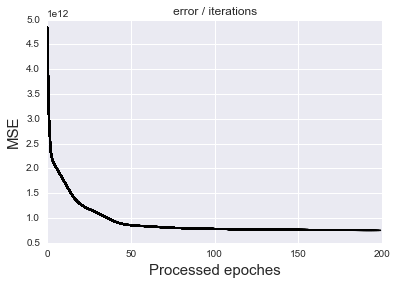

In [324]:
sess = tf.InteractiveSession()

# Create a summary to monitor cost tensor (tensorboard)
tf.scalar_summary("MSE", mean_square_error)

# merge all summaries (tensorboard)
merged_summary_op = tf.merge_all_summaries()

sess.run(tf.initialize_all_variables())
summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())


XX = []
YY = []
min_error = np.inf
for k in range(epoches):
    # iterrate trough every row (with batch size of 1)
    for i in range(X_train.shape[0]/batch_len):
        Xs,ys = batch_gen.getNextBatch()
        _, error, summary = sess.run([training, mean_square_error, merged_summary_op],  feed_dict={x: Xs, y_:ys})
        summary_writer.add_summary(summary, k * batch_len + i)
    
    YY.append(error)
    XX.append(k)
    plt.plot(XX, YY, 'black')
    plt.ylabel('MSE', fontsize=15)
    plt.xlabel('Processed epoches', fontsize=15)
    plt.title('', fontsize=20)
    plt.grid('on')
    plt.title('error / iterations')
    plt.savefig("out.png")
    display.display(display.Image(filename="out.png"))
    display.clear_output(wait=True)

### error on unseen data 

MSE: 5.73741e+12
mean error: 0.379773519584
std error: 0.323984028157


(0, 1)

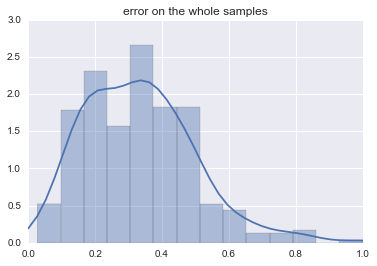

In [325]:
print("MSE: " + str( sess.run(mean_square_error,  feed_dict={x: X_test, y_:y_test}) ) )
reg_pred = sess.run(y, feed_dict={x:X_test})
scores = []
for i in range(len(reg_pred)):
    ee = getErr(reg_pred[i],y_test[i])
    scores.append(ee)
print("mean error: " + str(np.mean(scores)))
print("std error: " + str(np.std(scores)))
plt.title('error on the whole samples')
sns.distplot(scores)
plt.plot()
plt.xlim([0,1])

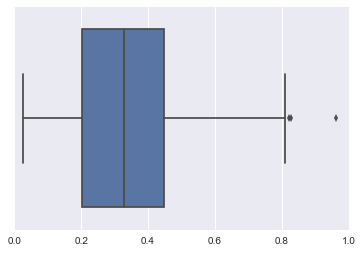

In [326]:
sns.boxplot(scores)
plt.xlim([0,1])
plt.show()

### model prediction vs reality

type=light&&pack=six_pack
median error: 0.168806004792
median raw error: 1489.79704762
max diff real: 18944.3005476


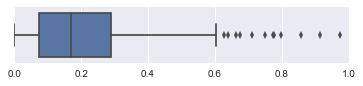

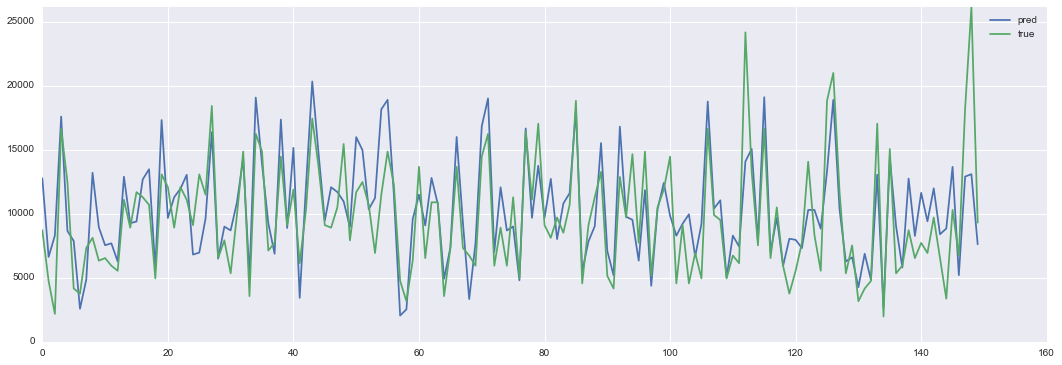

type=other&&pack=pint
median error: 0.297264541015
median raw error: 287.218121693
max diff real: 4823.14436628


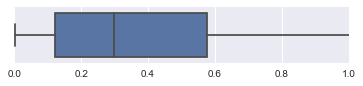

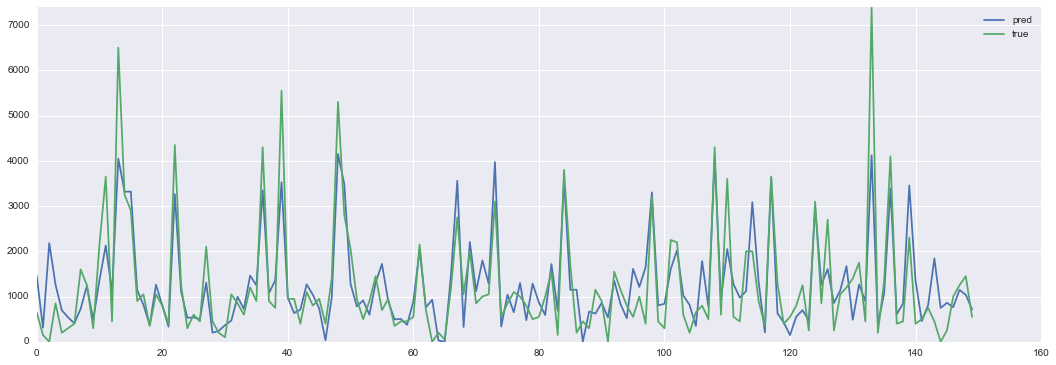

type=imported&&pack=pint
median error: 0.181077333711
median raw error: 1288.95575397
max diff real: 21436.1534863


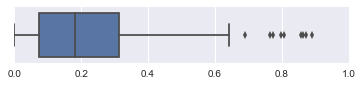

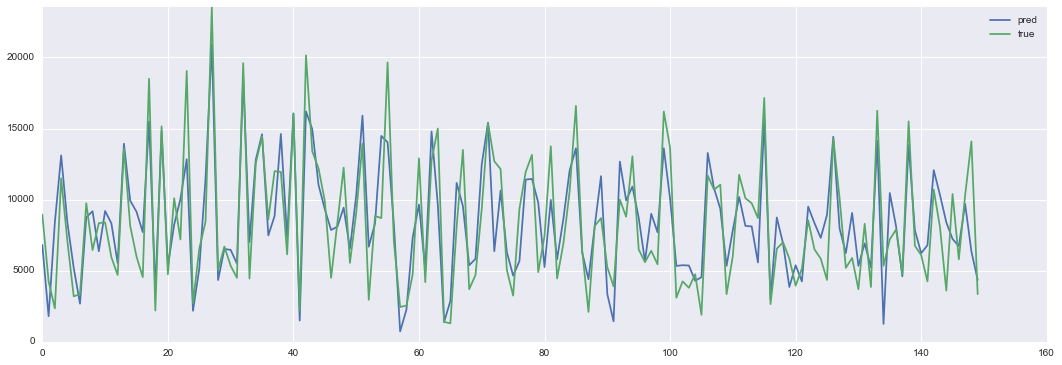

type=other&&pack=single
median error: 0.359248490325
median raw error: 4773.0589127
max diff real: 37508.4722302


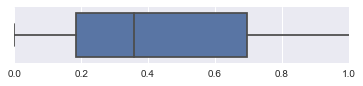

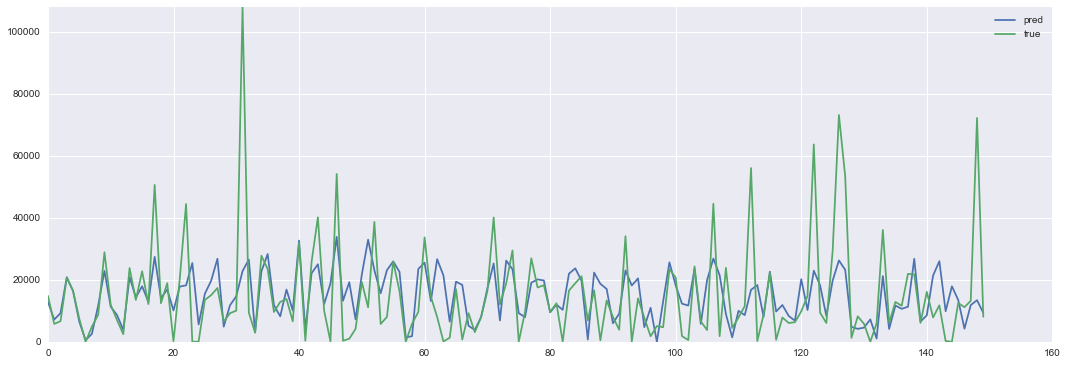

type=pilsner&&pack=six_pack
median error: 0.111756860014
median raw error: 5776.50790476
max diff real: 263361.896167


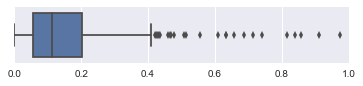

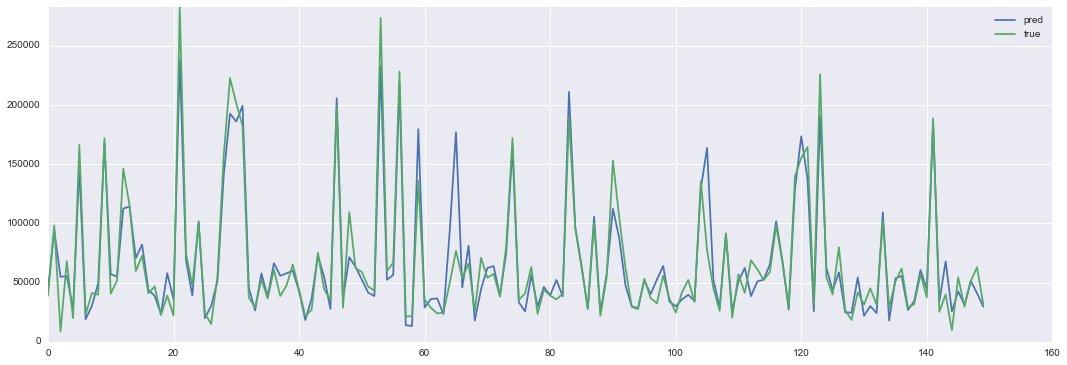

type=special&&pack=pint
median error: 0.501934163654
median raw error: 647.098478836
max diff real: 4935.15724507


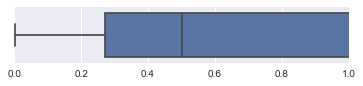

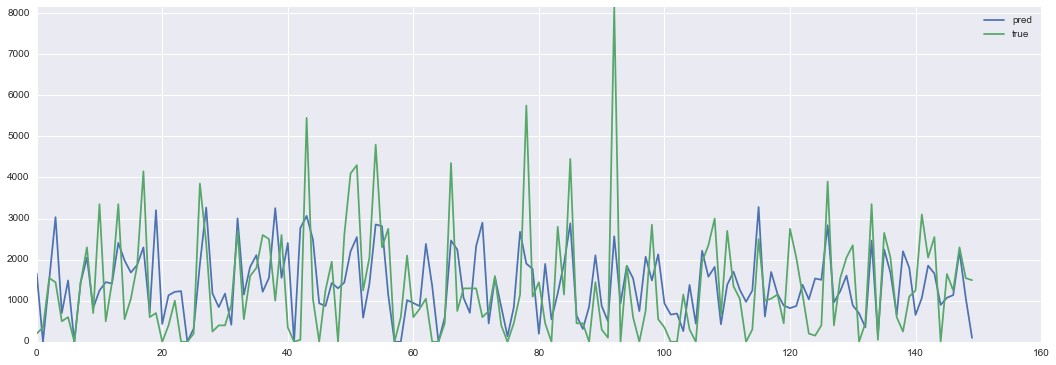

type=strong_pils&&pack=crate
median error: 0.310767544024
median raw error: 31549.7061612
max diff real: 427020.467429


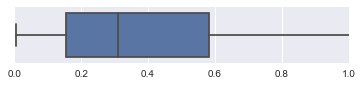

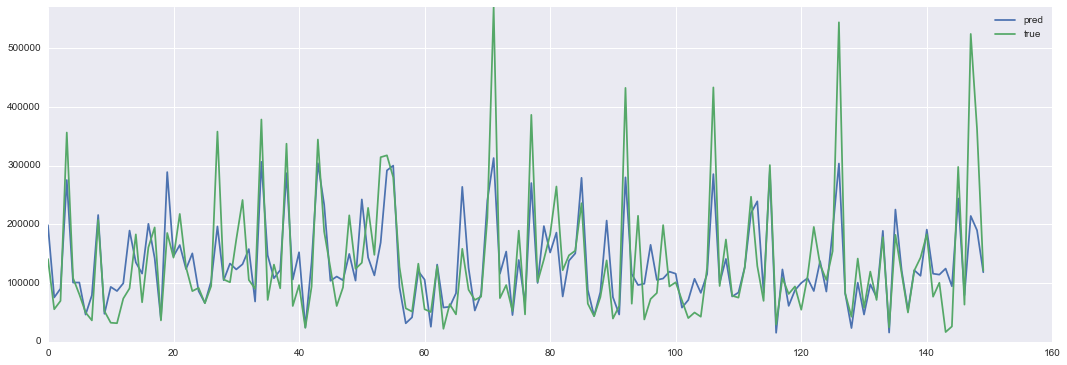

type=strong_pils&&pack=single
median error: 0.160117011603
median raw error: 565.611948413
max diff real: 11780.3945675


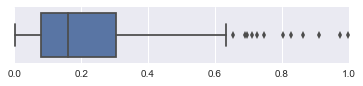

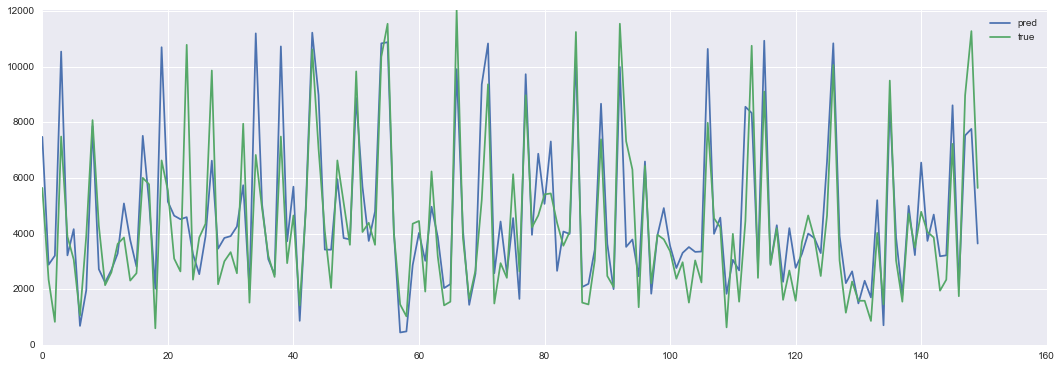

type=pilsner&&pack=crate
median error: 0.37387623731
median raw error: 7323.32733333
max diff real: 123157.515333


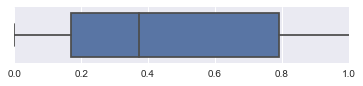

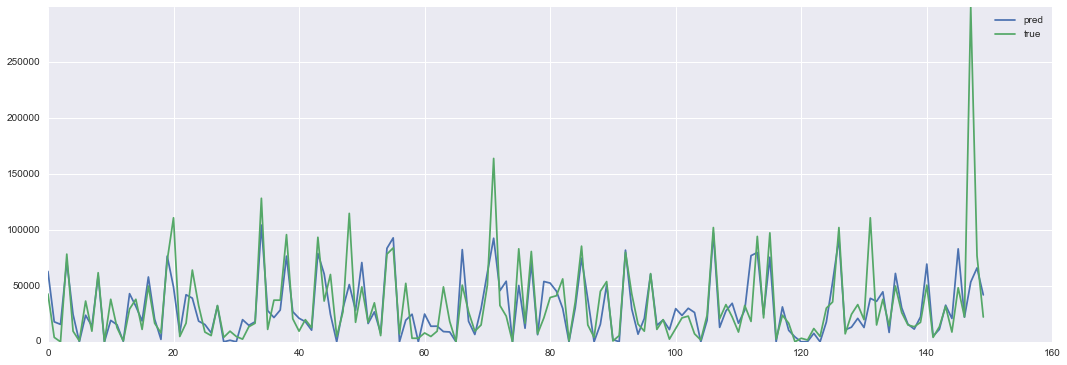

type=light&&pack=single
median error: 0.384335148905
median raw error: 348.861440476
max diff real: 4164.57215873


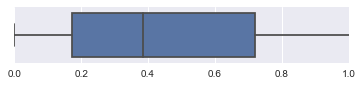

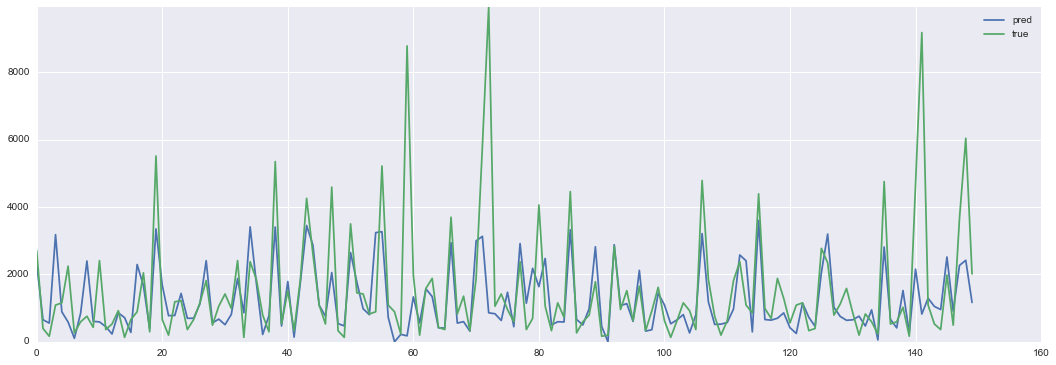

type=shandy&&pack=single
median error: 0.529398563558
median raw error: 369.912507937
max diff real: 3667.52850397


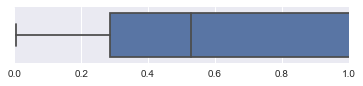

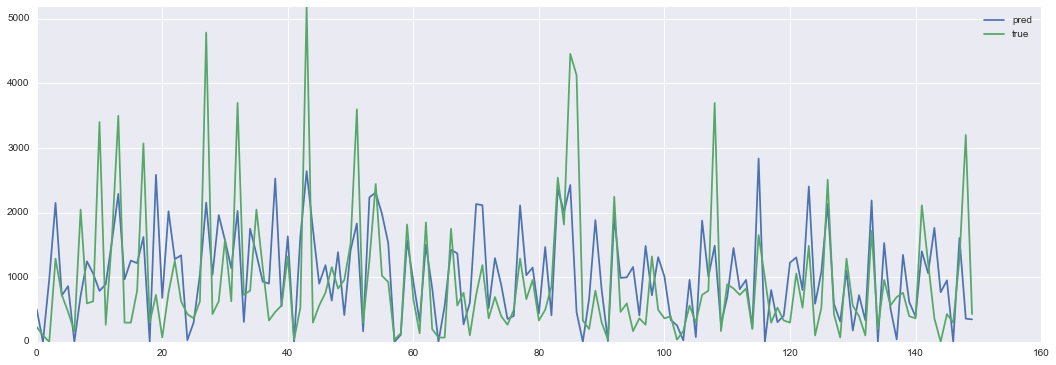

type=strong_pils&&pack=pint
median error: 0.136993909832
median raw error: 794.02536075
max diff real: 10514.5518338


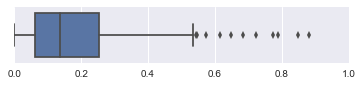

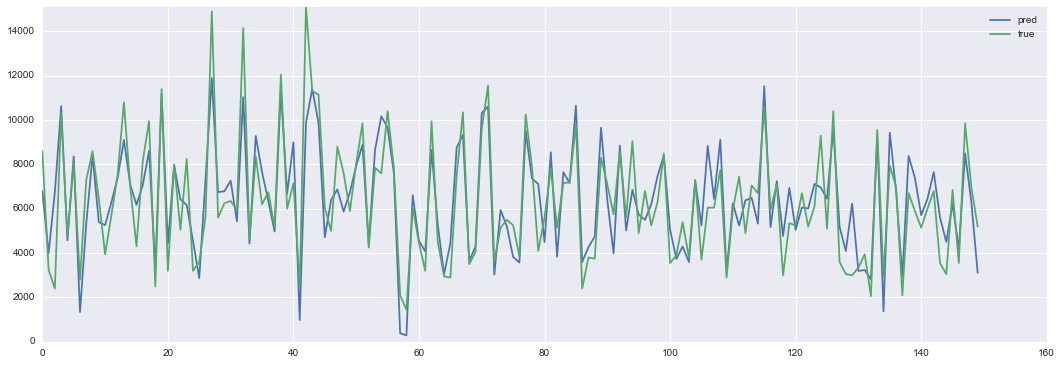

type=strong_pils&&pack=six_pack
median error: 0.110116227369
median raw error: 5769.99245238
max diff real: 115953.54481


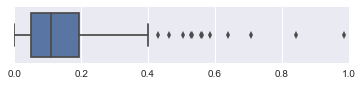

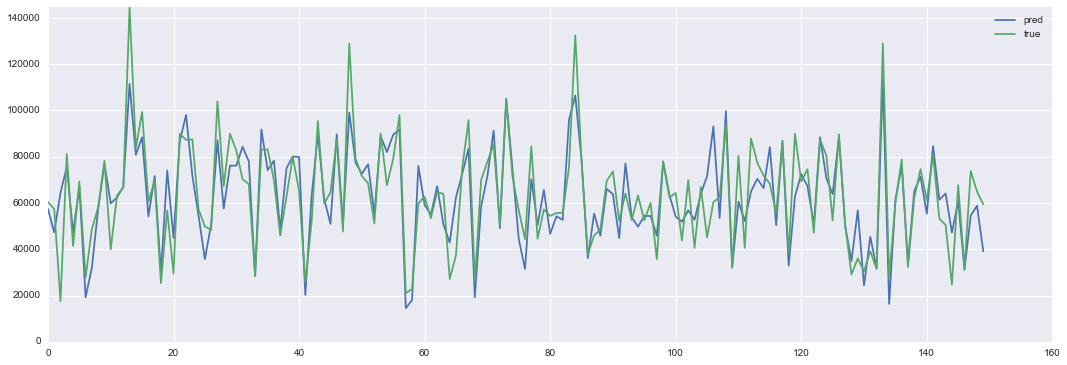

type=imported&&pack=six_pack
median error: 0.170051469041
median raw error: 5525.51519048
max diff real: 95349.5223095


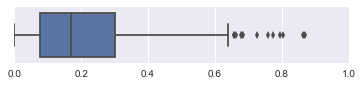

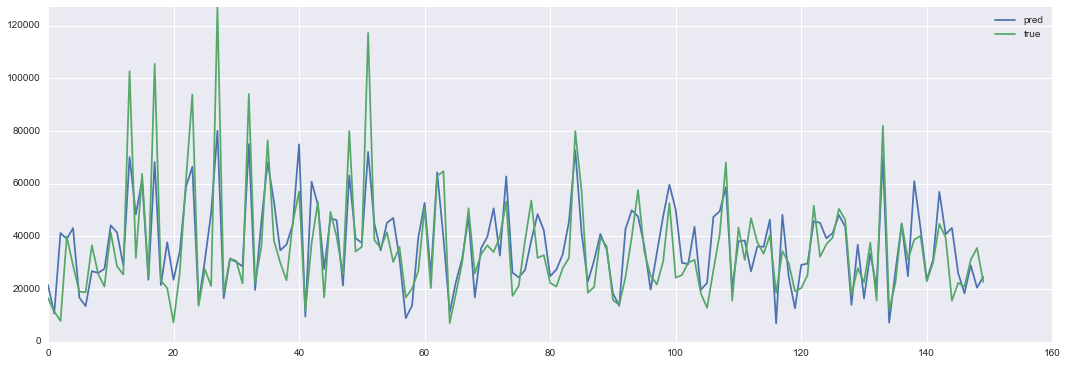

type=extra_strong&&pack=pint
median error: 0.129622114775
median raw error: 1954.06405123
max diff real: 37281.127874


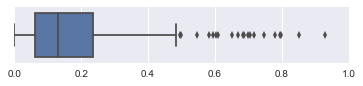

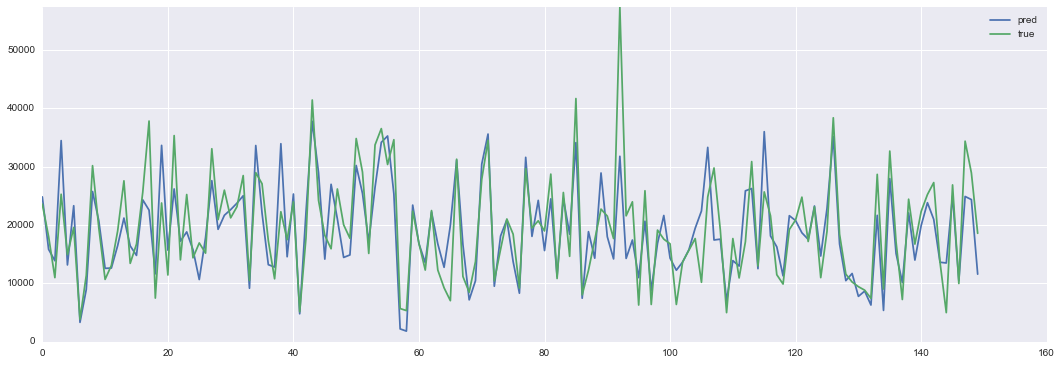

type=imported&&pack=single
median error: 0.258318239538
median raw error: 1784.56726984
max diff real: 31479.3152381


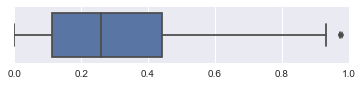

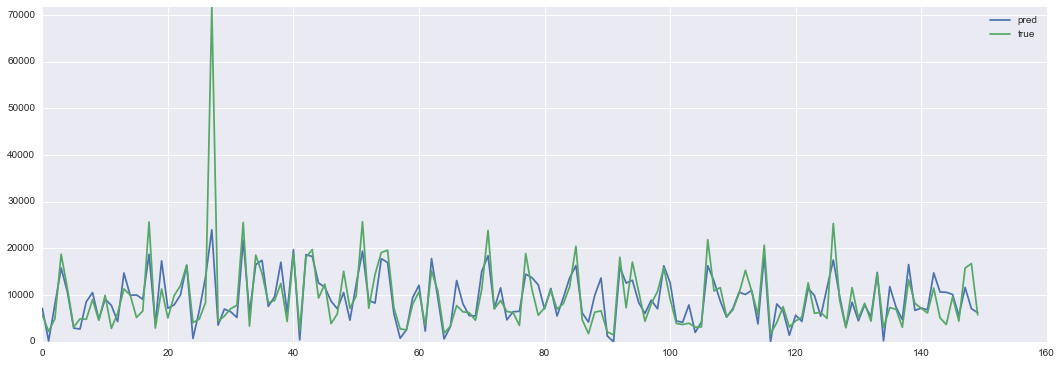

type=pilsner&&pack=single
median error: 0.336821646194
median raw error: 44097.2395198
max diff real: 797049.765472


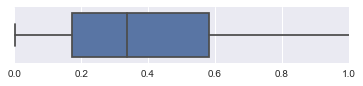

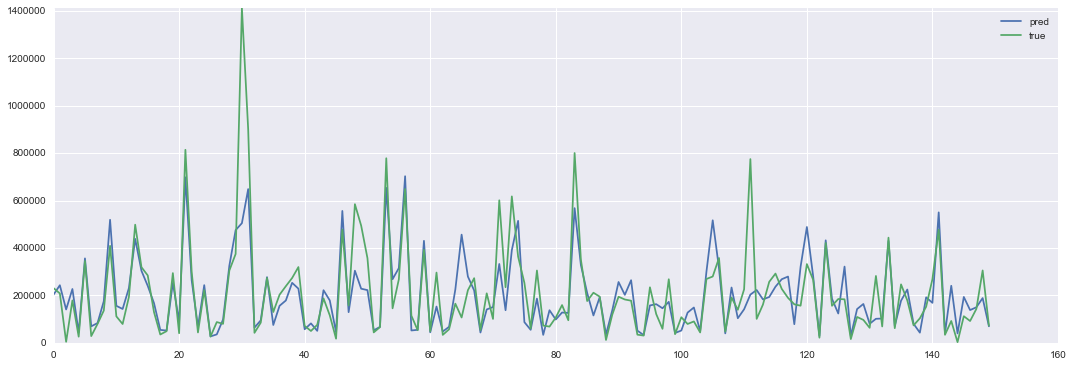

type=special&&pack=six_pack
median error: 0.243686576094
median raw error: 1836.92038095
max diff real: 26312.5543333


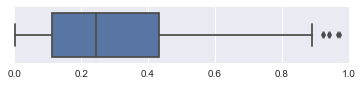

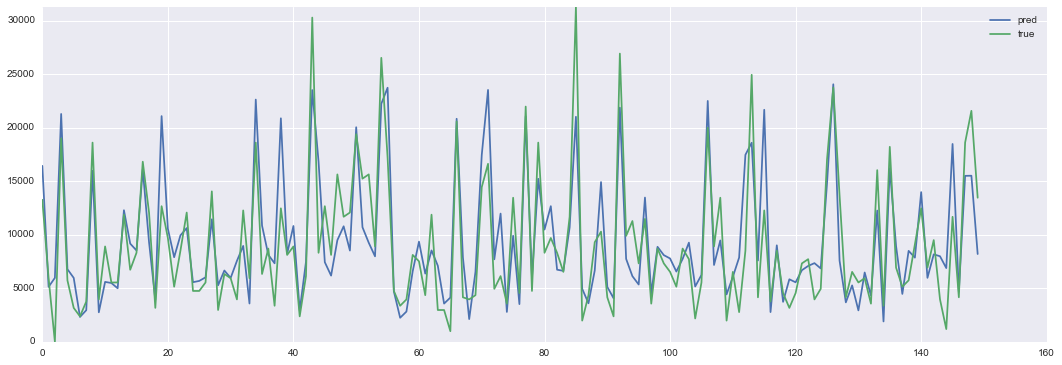

In [321]:
N = 150
for i in range(y_test.shape[1]):
    print(labels[i])
    scores = []
    raw_errs = []
    for j in range(len(pred)):
        e = getErr(pred[j ,i],y_test[j,i])
        scores.append(e)
        raw_errs.append(abs(pred[j ,i]-y_test[j,i]))
    scores = [ x for x in scores if x  < 999 ]
    print("median error: " + str(np.median(scores)))
    print("median raw error: " + str(np.median(raw_errs)))
    print("max diff real: " + str(abs(max(pred[:,i])) - abs(min(pred[:,i])) ))
    plt.figure(figsize=(6,1))
    sns.boxplot(scores)
    plt.xlim([0,1])
    plt.show()
    plt.figure(figsize=(18,6))
    plt.plot(reg_pred[:N , i],label='pred' )
    plt.plot(y_test[:N , i],label='true')
    plt.legend()
    plt.ylim([0, max(y_test[ :N , i])])
    plt.show()

The model succeeds to model some labels (type=extra_strong&&pack=pint : median error: 0.129622114775). However, it fails totally for some other, which explains the overall error. 

Moreover, most of the errors seems to be related to outliers. Missing data like the marketing budget and event good explain an important number of errors